C:\Users\joakul\Anaconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


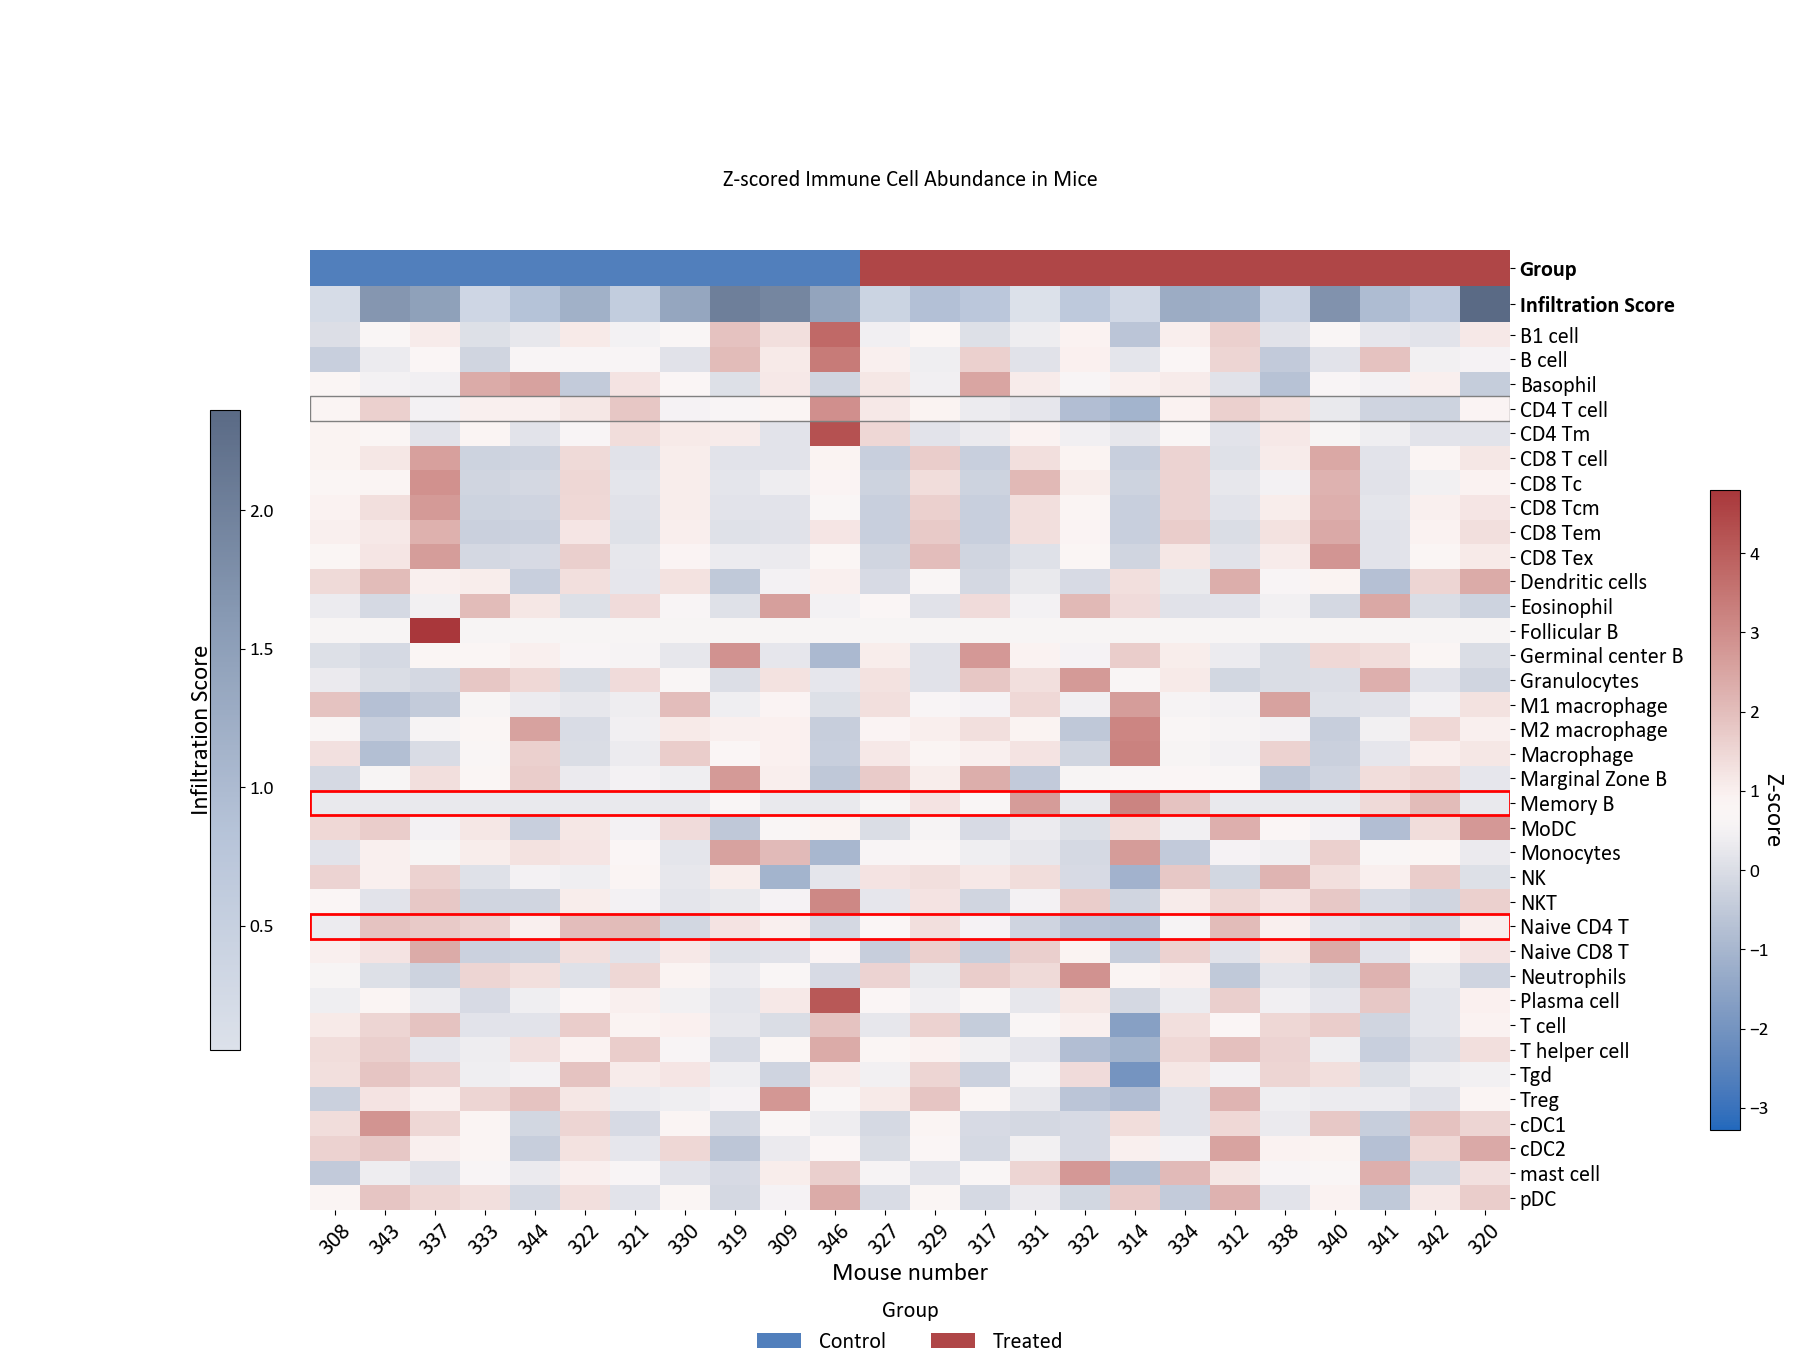

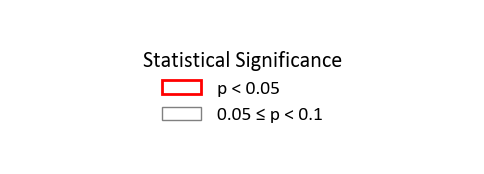

      Cell_type   p_value  Mean_Control  Mean_Treated Higher_in
14     Memory_B  0.008492      0.000173      0.004454   Treated
27  Naive_CD4_T  0.045054      0.006327      0.004062   Control
6    CD4_T_cell  0.055835      0.027627      0.018892   Control


In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from scipy.stats import zscore
import scipy.stats as stats

plt.rcParams['font.family'] = 'Calibri'

# --- Load data ---
file_path = "ImmuCellAI_mouse_abundance_result_threshold_9.xlsx"
df = pd.read_excel(file_path)
df = df[df["Mouse number"] != 311]  # Exclude outlier mouse
df.set_index("Mouse number", inplace=True)
df_sorted = df.sort_values("Group")

# --- Data prep for analysis ---
cell_types = df.columns[2:]  # Exclude mouse number and group columns
group_control = df[df["Group"] == "Control"]
group_treated = df[df["Group"] == "Treated"]

# --- Statistical testing ---
results = []
for cell in cell_types:
    data_control = group_control[cell]
    data_treated = group_treated[cell]

    # Shapiro-Wilk test (normality)
    p_norm_control = stats.shapiro(data_control).pvalue
    p_norm_treated = stats.shapiro(data_treated).pvalue

    # Levene’s test (equal variances)
    p_var = stats.levene(data_control, data_treated).pvalue

    # Choose test
    if p_norm_control > 0.05 and p_norm_treated > 0.05 and p_var > 0.05:
        test = "t-test"
        stat, p_val = stats.ttest_ind(data_control, data_treated)
    else:
        test = "Mann-Whitney U"
        stat, p_val = stats.mannwhitneyu(data_control, data_treated, alternative='two-sided')

    results.append({
        "Cell_type": cell,
        "Normality_p_Control": p_norm_control,
        "Normality_p_Treated": p_norm_treated,
        "Equal_variance_p": p_var,
        "Test": test,
        "Statistic": stat,
        "p_value": p_val
    })

results_df = pd.DataFrame(results).sort_values("p_value")

# --- Z-score normalization for visualization ---
cell_types = df.columns.difference(['Group', 'Infiltration_score'])
zscored = df_sorted[cell_types].apply(zscore)
zscored.columns = zscored.columns.str.replace('_', ' ')

# Custom colormap
colors = ["#DCE1EA", "#B7C4D9", "#899BB5", "#5A6A85"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Sample color annotations
group_palette = {'Control': '#517FBC', 'Treated': '#AF4647'}
group_colors = df_sorted['Group'].map(group_palette)

norm = Normalize(vmin=df_sorted['Infiltration_score'].min(), vmax=df_sorted['Infiltration_score'].max())
infiltration_colors = df_sorted['Infiltration_score'].map(lambda x: custom_cmap(norm(x)))

col_colors = pd.DataFrame({
    'Group': group_colors,
    'Infiltration Score': infiltration_colors
}, index=df_sorted.index)

# --- Clustermap ---
g = sns.clustermap(
    zscored.T,
    cmap="vlag",
    center=0,
    col_colors=col_colors,
    col_cluster=False,
    row_cluster=False,
    xticklabels=True,
    yticklabels=True,
    figsize=(20, 16),
    cbar_pos=None
)

# Axis tick styling
for tick in g.ax_col_colors.yaxis.get_ticklabels():
    tick.set_fontsize(16)
    tick.set_fontweight('bold')

# Add colorbar for Z-scores
norm_zscore = Normalize(vmin=zscored.min().min(), vmax=zscored.max().max())
sm = ScalarMappable(cmap="vlag", norm=norm_zscore)
cbar_ax = g.fig.add_axes([1.0, 0.2, 0.015, 0.4])
cbar = g.fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Z-score", fontsize=18, rotation=-90, labelpad=10)
cbar.ax.tick_params(labelsize=14)

# Title
g.fig.suptitle("Z-scored Immune Cell Abundance in Mice", fontsize=16, x=0.6, y=0.8)

# Group legend
legend_patches = [Patch(facecolor=color, label=label) for label, color in group_palette.items()]
g.ax_heatmap.legend(
    handles=legend_patches,
    title="Group",
    title_fontsize=16,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.08),
    ncol=2,
    frameon=False
)

# Infiltration score colorbar
cbar_ax_infiltration = g.fig.add_axes([0.25, 0.25, 0.015, 0.4])
cbar_infiltration = g.fig.colorbar(
    ScalarMappable(norm=norm, cmap=custom_cmap),
    cax=cbar_ax_infiltration
)
cbar_infiltration.set_label('Infiltration Score', fontsize=18, labelpad=-60, rotation=90)
cbar_infiltration.ax.tick_params(labelsize=14)

# Layout adjustment
g.fig.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)

# Axis label styling
g.ax_heatmap.set_xlabel("Mouse number", fontsize=18)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=16, rotation=45)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=16)

# --- Highlight significant rows with rectangles ---
yticklabels = g.ax_heatmap.get_yticklabels()
row_labels = [label.get_text() for label in yticklabels]

red_outline = set()
gray_outline = set()

for _, row in results_df.iterrows():
    name = row["Cell_type"].replace("_", " ")
    p = row["p_value"]
    if p < 0.05:
        red_outline.add(name)
    elif p < 0.1:
        gray_outline.add(name)

for idx, label in enumerate(row_labels):
    y = idx
    if label in red_outline:
        rect = Rectangle((0, y), zscored.shape[0], 1, linewidth=2, edgecolor='red', facecolor='none')
        g.ax_heatmap.add_patch(rect)
    elif label in gray_outline:
        rect = Rectangle((0, y), zscored.shape[0], 1, linewidth=1, edgecolor='gray', facecolor='none')
        g.ax_heatmap.add_patch(rect)

plt.show()

# --- Create legend for significance rectangles ---
legend_elements = [
    Patch(facecolor='none', edgecolor='red', linewidth=2, label='p < 0.05'),
    Patch(facecolor='none', edgecolor='gray', linewidth=1, label='0.05 ≤ p < 0.1')
]

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')
ax.legend(
    handles=legend_elements,
    loc='center',
    frameon=False,
    fontsize=14,
    title="Statistical Significance",
    title_fontsize=16
)
plt.show()

# --- Add means and compare direction ---
for i, row in enumerate(results):
    cell = row["Cell_type"]
    results[i]["Mean_Control"] = group_control[cell].mean()
    results[i]["Mean_Treated"] = group_treated[cell].mean()

results_df = pd.DataFrame(results).sort_values("p_value")
results_df["Higher_in"] = results_df.apply(
    lambda row: "Treated" if row["Mean_Treated"] > row["Mean_Control"] else "Control",
    axis=1
)

# Filter significant results
significant = results_df[results_df["p_value"] < 0.1].copy()
print(significant[["Cell_type", "p_value", "Mean_Control", "Mean_Treated", "Higher_in"]])
